# Formation PyTorch : les bases pour être autonome 
#### 19 avril 2023 de 9h à 17h à l'OMP (salle Coriolis)



# Partie 3

Dans cette troisième partie, nous allons voir comment adapter des modules PyTorch pour créer ses propres couches et comment définir ses propres fonctions de régularisation.

## Définir ses propres couches de convolution 


Les noyaux de convolution de la première couche d'AlexNet (voir partie 2) ressemblent à des filtres de Gabor. On pourrait initialiser les noyaux de convolution comme des filtres de Gabor ou même optimiser des filtres de Gabor comme proposé dans [2] plutôt que des noyaux classiques.

Dans cette sous-partie, on va définir notre propre couche de filtre de Gabor. Précisémment, on va implémenter la partie réelle d'un filtre de Gabor qui est définie comme suit : 

$$g(x,y; \lambda, \psi, \sigma, \gamma, \theta) = exp(-\frac{x'^2 + \gamma^2 \cdot y'^2}{2\sigma^2}) \cdot cos(2\pi \frac{x'}{\lambda} + \psi)$$
avec 
$$x' = x \: cos \: \theta + y \: sin \: \theta ; \:\:\: y' = -x \: sin \: \theta + y \: cos \: \theta$$ 

où $\lambda > 0$, $\psi \in [0, 2\pi]$, $\sigma > 0$ et $\gamma >0$ sont des paramètres à optimiser. $\theta \in [0, \pi[$ prendra plusieurs valeurs déterminées pour obtenir des filtres avec différentes orientations.

Le code ci-dessous est fortement inspiré du code au lien suivant : https://gist.github.com/DerThorsten/7117b9b7a41da4e0a13d6500f9a1b657

[2] Alekseev, Andrey, and Anatoly Bobe. "GaborNet: Gabor filters with learnable parameters in deep convolutional neural network." 2019 International Conference on Engineering and Telecommunication (EnT). IEEE, 2019.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, f1_score

En fait, on souhaiterait conserver les propriétés et fonctions d'une couche de convolution classique, mais en redéfinissant uniquement les poids de la convolution. On va donc écire une classe qui hérite de torch.nn.modules.conv.Conv2d.

AlexNet avait 64 convolutions par canal de dimensions spatiales (11x11) pour sa première couche. On fait la même chose ici : pour chaque canal, on apprend 64 filtres de Gabor de taille (11x11). Afin d'avoir des filtres invariants aux rotations, on fait varier le paramètre $\theta$, comme indiqué ci-dessus, pour 8 valeurs entre $0$ et $2\pi$. Pour un $\theta$ donné, il reste donc 8 couples différents de paramètres $(\lambda, \psi, \sigma, \gamma)$ à optimiser. 

On a donc des filtres de Gabor de tailles $(8 \times 8 \times 3 \times 11 \times 11)$ où la première dimension correspond aux couples de paramètres $(\lambda, \psi, \sigma, \gamma)$, la deuxième dimension correspond à $\theta$, la troisième dimension correspond aux canaux RGB et les deux dernières dimensions correspondent aux dimensions spatiales.

In [2]:
class GaborFilters(nn.modules.conv.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, bias=False,
                 padding_mode='zeros', device=None, dtype=None, n_thetas=5):
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias_ = bias
        self.padding_mode = padding_mode
        self.device = device
        self.dtype=dtype
        self.n_thetas = self.out_channels//8
        
        # A compléter
        super().__init__(...)
                
        # Initialisation des paramètres lambda, psi, sigma et gamma
        lambda_init_values = torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)*32
        psi_init_values = torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)*2*math.pi
        sigma_init_values = torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)*10
        gamma_init_values = torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)
        
        self.lambda_ = torch.nn.Parameter(lambda_init_values, requires_grad=True)
        self.psi = torch.nn.Parameter(psi_init_values,requires_grad=True)
        self.sigma = torch.nn.Parameter(sigma_init_values, requires_grad=True)
        self.gamma = torch.nn.Parameter(gamma_init_values, requires_grad=True)
        
        # On fixe les valeurs de theta
        thetas = torch.linspace(0., math.pi*(self.n_thetas-1)/self.n_thetas, self.n_thetas)
        # A compléter
        self.register_buffer(...)
        
    @property
    def weight(self):
        # A compléter
        ...

    def gabor_filter(self):
        x = torch.arange(self.kernel_size[0], dtype=torch.float32) -  (self.kernel_size[0] - 1)/2
        x = x.view(1, 1, 1, 1, self.kernel_size[0])
        y = torch.arange(self.kernel_size[1], dtype=torch.float32) -  (self.kernel_size[1] - 1)/2
        y = y.view(1, 1, 1, self.kernel_size[1], 1)
        
        thetas = self.thetas.view(1, -1, 1, 1, 1)

        x_ =  x * torch.cos(thetas) + y * torch.sin(thetas)
        y_ = -x * torch.sin(thetas) + y * torch.cos(thetas)

        gb = torch.exp(-0.5 * ((x_ ** 2 + self.gamma**2 * y_ ** 2) / (1e-2+self.sigma) ** 2)) \
                 * torch.cos(2.0 * math.pi  * x_ / (1e-2+F.relu(self.lambda_)) + self.psi)
        
        gb = gb.view(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])

        return gb

On définit un modèle équivalent au TinyAlexNet de la partie 2 mais on substitue la première couche de convolution à une couche de filtres de Gabor. 

In [5]:
class GaborAlexNet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0):
        super(GaborAlexNet, self).__init__()
        
        self.features_gabor = GaborFilters(3, 64, kernel_size=11, stride=4, padding=2)
        
        self.features = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(36, 16),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(16, num_classes)
        )
        
        #torch.manual_seed(0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.features(inputs)
        return x

    def forward(self, inputs):
        x = self.features_gabor(inputs)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
model = GaborAlexNet(num_classes=2)
model.features_gabor.weight.shape

torch.Size([64, 3, 11, 11])

In [7]:
torch.save({'state_dict': model.state_dict()}, 'gabor_net.pth.tar')
checkpoint = torch.load('gabor_net.pth.tar')
checkpoint['state_dict'].keys()

odict_keys(['features_gabor.weight', 'features_gabor.lambda_', 'features_gabor.psi', 'features_gabor.sigma', 'features_gabor.gamma', 'features_gabor.thetas', 'features.2.weight', 'features.2.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias'])

Affichons les filtres de Gabor à l'initialisation du modèle :

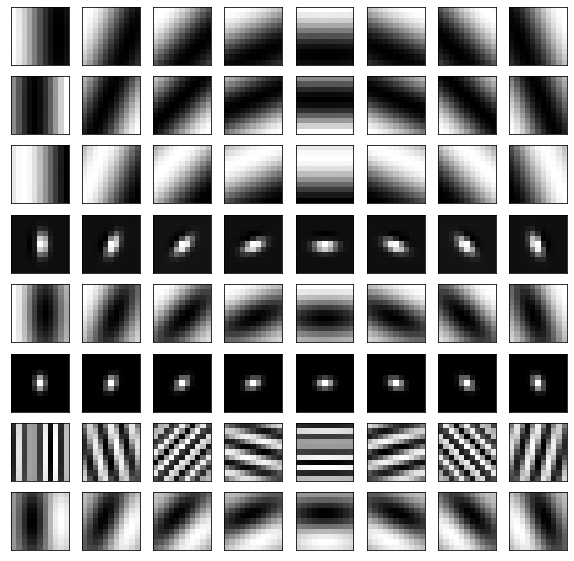

In [8]:
model = GaborAlexNet(num_classes=2)

fig, ax = plt.subplots(8,8, figsize=(10,10))
k = 0
for i in range(8):
    for j in range(8):
        # A compléter 
        ax[i,j].imshow(..., cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.show()

Vérifions que nous avons bien défini les filtres de Gabor et que nous pouvons optimiser ses paramètres :

In [9]:
model = GaborAlexNet(num_classes=2)
print(model.features_gabor.lambda_.grad)
x = torch.randn((1, 3, 125, 125)) # Image aléatoire
out = model(x)
loss = F.cross_entropy(out, torch.ones(1).long()) # Label aléatoire
loss.backward()
model.features_gabor.lambda_.grad.shape

None


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


torch.Size([8, 1, 3, 1, 1])

## Régularisation

On peut facilement régulariser la norme L2 des poids d'un modèle avec l'argument "weight_decay" des optimizer Pytorch. Regardez par exemple les arguments de Adam (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=weight_decay). Néanmoins, on pourrait vouloir définir d'autres types de régularisation. 

Ici, on va régulariser la norme L1 des poids des couches denses de GaborAlexNet. 

In [10]:
def L1_regularization(submodel):
    """
    Arg:
        * submodel: a torch.nn.modules.container.Sequential object
    Output:
        * regularization term
    """
    # A compléter
    ...
    return reg

On vérifie que la régularisation fonctionne bien :

In [11]:
model = GaborAlexNet(num_classes=2)
print(model.classifier[1].weight.grad)
reg = L1_regularization(model.classifier)
reg.backward()
model.classifier[1].weight.grad.shape

None


torch.Size([16, 36])

## Application au problème de la partie 2

In [13]:
import numpy as np

img = np.load('img.npy')
gt = np.load('gt.npy')

In [14]:
class Dataset(torch.utils.data.Dataset):
    ...

In [18]:
hyperparams = {'ignored_labels': [0], 'patch_size': 125}
dataset = Dataset(img, gt, hyperparams)
train_dataset, val_dataset = ...

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

In [19]:
device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
num_epochs = 1
best_val = np.inf
optimizer = torch.optim.Adam([{'params': ..., 'lr':5e-3}, 
                              {'params': ..., 'lr':1e-3}])

In [20]:
for epoch in range(num_epochs):
    y_pred, y_true = [], []
    for patch, label in tqdm(train_loader):
        patch, label = patch.to(device), label.to(device)-1
        logits = model(patch) # model;forward(patch)
        loss = F.cross_entropy(logits, label)
        loss.backward() # Calcul du gradient 
        optimizer.step() # Mise à jour des paramètres
        optimizer.zero_grad() # Mise à zéro du gradient
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
          
    train_accuracy = accuracy_score(y_pred, y_true)
    train_f1 = f1_score(y_pred, y_true)
    
    y_pred, y_true = [], []
    for patch, label in tqdm(val_loader):
        patch, label = patch.to(device), label.to(device)-1
        with torch.no_grad():
            logits = model(patch)
        val_loss = F.cross_entropy(logits, label)
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
        
    val_accuracy = accuracy_score(y_pred, y_true)
    val_f1 = f1_score(y_pred, y_true)
    
    if val_loss.item() < best_val:
        best_val = val_loss.item()
        torch.save({'epoch': epoch, 
                    'best_loss': best_val, 
                    'state_dict': model.state_dict()}, 'best_model.pth.tar')
        
    print('[Train] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                            loss.item(), train_accuracy, train_f1))
    print('[Val] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                          val_loss.item(), val_accuracy, val_f1))

100%|██████████| 185/185 [00:28<00:00,  6.56it/s]


[Train] 	 Loss: 0.4810 | Accuracy: 0.6916 | F1 score: 0.0063
[Val] 	 Loss: 0.4188 | Accuracy: 0.6962 | F1 score: 0.0000


L'optimisation converge beaucoup moins bien avec les filtres de Gabor. L'optimisation, en particulier, semble beaucoup plus sensible à l'intialisation des paramètres des filtres. Il faudrait creuser davantage pour mieux régler les hyper-paramètres du modèle et de l'optimisation.

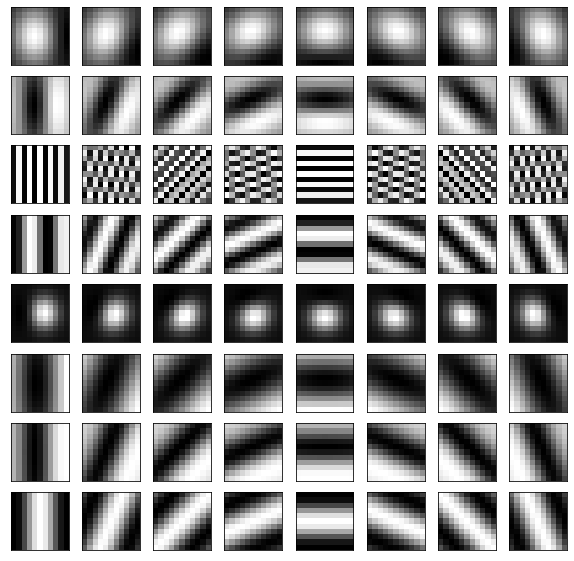

In [21]:
fig, ax = plt.subplots(8,8, figsize=(10,10))
k = 0
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(..., cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.show()